# 13주차 과제_0530(금)

딥러닝 파이토치 교과서 ch7. 5 p.393~417

# 7.5 LSTM

RNN : 가중치 업데이트 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에 기울기가 사라지는 소멸 문제 발생 $\rightarrow$ LSTM, GRU 같은 확장된 RNN 방식 사용

## 7.5.1 LSTM 구조

**LSTM 순전파**

- 망각 게이트 : 과거 정보를 어느 정도 기억할지 결정

    과거 정보와 현재 데이터를 입력 받아 시그모이드를 취한 후 그 값을 과거 정보에 곱해 줌

    -> 시그모이드의 출력이 0이면 과거의 정보는 버리고 1이면 과거 정보는 온전히 보존함

    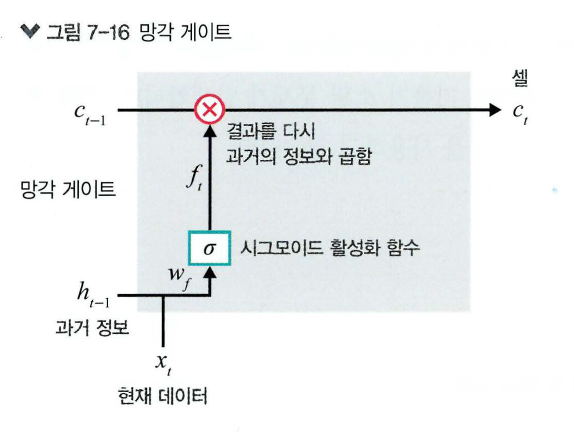

- 입력 게이트 : 현재 정고를 기억하기 위해 만들어짐

    과거 정보와 현재 데이터를 입력 받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량 결정

    계산한 값이 1이면 입력이 들어올 수 있도록 허용, 0이면 차단함

    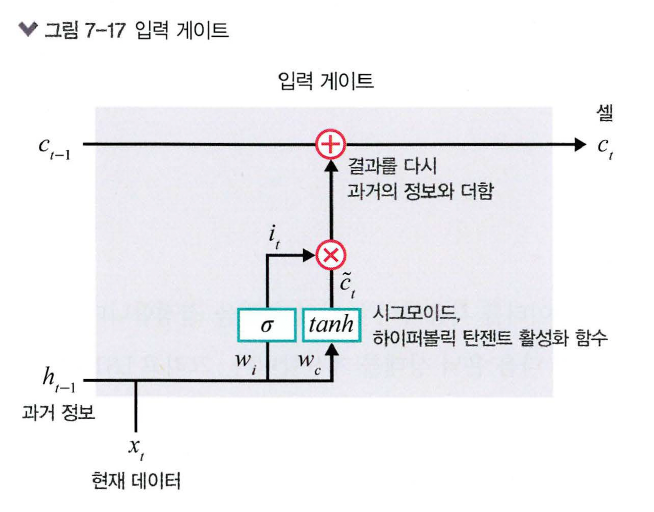

- 셀 : 각 단계에 대한 은닉 노드

    [셀 업데이트 방법]

    망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트 함

    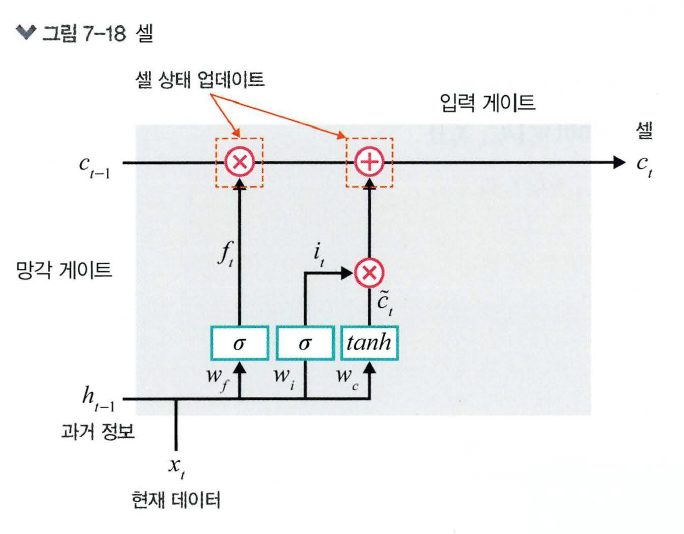

- 출력 게이트 : 과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정

    이전 은닉 상테와 t번째 입력을 고려해서 다음 은닉 상태 계산

    LSTM에서는 이 은닉 상태가 그 시점에서의 출력이 됨

    계산한 값이 1이면 의미 있는 결과로 최종 출력, 0이면 해당 연산을 출력 하지 않음

    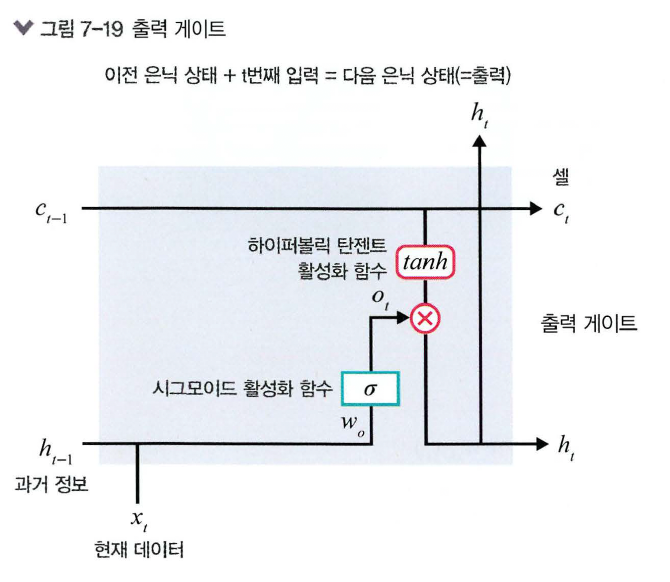

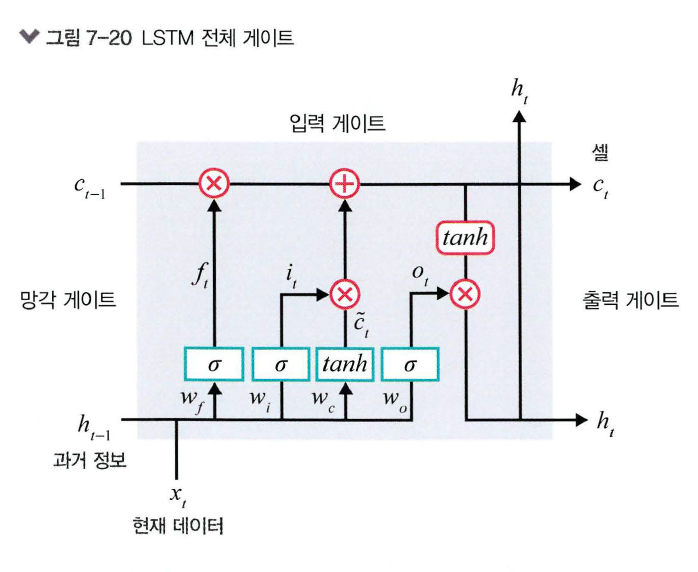

**LSTM 역전파**

LSTM은 셀을 통해 역전파를 수행하기 때문에 중단 없는 기울기라고도 불림 > 최종 오차가 모든 노드에 전파되는데 이때 셀을 통해 중단 없이 전파됨

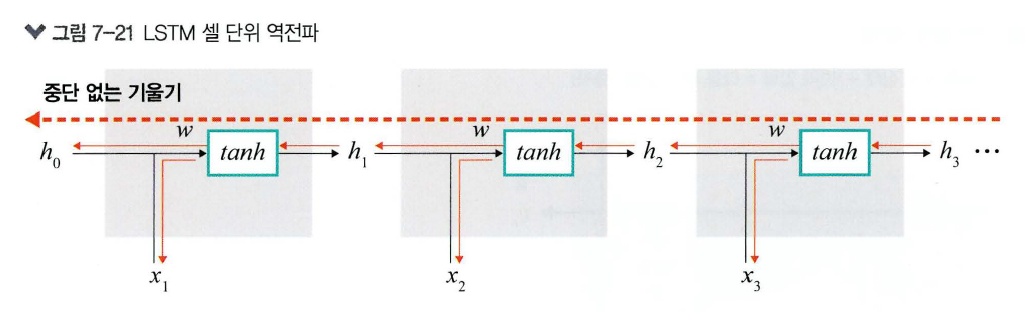

$$\begin{align}
t_t & = tanh(w_{hh}h_{t-1}+w_{xh}x_t) \\
& = tanh((w_{hh}\ w_{xh} \begin{pmatrix} h_{t-1}\\x_t\end{pmatrix}) \\
& = tanh(w\begin{pmatrix} h_{t-1}\\x_t\end{pmatrix})
\end{align}$$

주의할 점 : 셀 단위로 오차가 전파된다고 해서 입력 방향으로 오차가 전파되지 않는 것은 아님

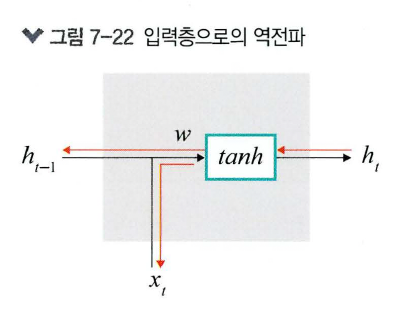

셀 내부적으로 오차가 입력으로 전파되는 경우도 있음

## 7.5.2 LSTM 셀 구현

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter # 파라미터 목록을 갖고 있는 라이브러리
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math # 수학과 관련되어 다양한 함수들과 상수들이 정의되어 있는 라이브러리

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False # GPU 사용에 필요

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor # GPU 사용에 필요

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [6]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [7]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = '../chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform = mnist_transform, train = True, download = True)
valid_dataset = MNIST(download_root, transform = mnist_transform, train = False, download = True)
test_dataset = MNIST(download_root, transform = mnist_transform, train = False, download = True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.87MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 146kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]


In [8]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

In [9]:
# 변수 값 지정
batch_size = 100
n_iters = 6000
num_epochs = n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [10]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy, cy)



```
self.x2h = nn.Linear(input_size, 4*hidden_size, bias = bias)
self.h2h = nn.Linear(input_size, 4*hidden_size, bias = bias)
```

4*hidden_size 사용 이유

gates = F.linear(input, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)

- input : 입력층으로 입력되는 훈련 데이터셋의 특성 수
- w_ih : 입력층과 은닉층 사이의 가중치
- b_ih : 입력층과 은닉층 사이의 바이어스
- hx : 은닉틍의 뉴런/유닛 개수
- w_hh : 은닉층과 은닉층 사이의 가중치
- b_ih : 은닉층과 은닉층 사이의 바이어스

이렇게 계산된 게이트는 gates.chunk(4,1)에 의해 네 개로 쪼개져서 망각, 입력, 셀, 출력 게이트를 의미하는 변수에 저장됨

$\rightarrow$ gates가 네 개로 쪼개지기 때문에 4를 곱해줌



```
ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)
```

첫 번째 파라미터 : 텐서를 몇 개로 쪼갤지 결정

두 번째 파라미터 : 어떤 차원을 기준으로 쪼갤지 결정

ex) dim = 1 : 열 단위로 텐서 분할 의미



In [11]:
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # 은닉층의 계층 개수, 배치크기, 은닉층의 뉴런 개수)형태를 갖는 은닉 상태를 0으로 초기화
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available(): # GPU 사용 유무 확인
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # 은닉층의 계층 개수, 배치크기, 은닉층의 뉴런 개수)형태를 갖는 셀 상태를 0으로 초기화
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

        outs = []
        cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
        hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out


In [12]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.237457513809204. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 1.0162721872329712. Accuracy: 73.87999725341797
Iteration: 1500. Loss: 0.4256852865219116. Accuracy: 89.63999938964844
Iteration: 2000. Loss: 0.28754276037216187. Accuracy: 93.33999633789062
Iteration: 2500. Loss: 0.062279555946588516. Accuracy: 95.37999725341797
Iteration: 3000. Loss: 0.09727098792791367. Accuracy: 95.73999786376953
Iteration: 3500. Loss: 0.07890735566616058. Accuracy: 96.69999694824219
Iteration: 4000. Loss: 0.01977785862982273. Accuracy: 97.02999877929688
Iteration: 4500. Loss: 0.037251248955726624. Accuracy: 96.55999755859375
Iteration: 5000. Loss: 0.0724782943725586. Accuracy: 97.02999877929688
Iteration: 5500. Loss: 0.12784495949745178. Accuracy: 97.05999755859375
Iteration: 6000. Loss: 0.01750139147043228. Accuracy: 97.77999877929688
Iteration: 6500. Loss: 0.037485670298337936. Accuracy: 97.31999969482422
Iteration: 7000. Loss: 0.010999397374689579. Accuracy: 97.73999786

In [14]:
# 테스트 데이터셋으르 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [15]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


## 7.5.3 LSTM 계층 구현

In [16]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
# 데이터셋 가져오기
data = pd.read_csv('SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [21]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True) # 'date' 칼럼을 인덱스로 사용

In [22]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float) # 데이터 형식을 변경할 때 astype() 사용

In [23]:
# 훈련과 레이블 분리
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [24]:
# 데이터 분포 조정
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [25]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [26]:
# LSTM 네트워크
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수 의미
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [27]:
# 변수 값 설정
num_epochs = 1000 # 1000번의 에포크
learning_rate = 0.0001 # 학습률을 0.0001로 지정

input_size = 5 # 입력 데이터셋의 칼럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [28]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch : %d, loss : %1.5f' % (epoch, loss.item()))

Epoch : 0, loss : 0.18287
Epoch : 100, loss : 0.05713
Epoch : 200, loss : 0.03855
Epoch : 300, loss : 0.03717
Epoch : 400, loss : 0.03599
Epoch : 500, loss : 0.03326
Epoch : 600, loss : 0.02937
Epoch : 700, loss : 0.02517
Epoch : 800, loss : 0.02214
Epoch : 900, loss : 0.02043


In [29]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

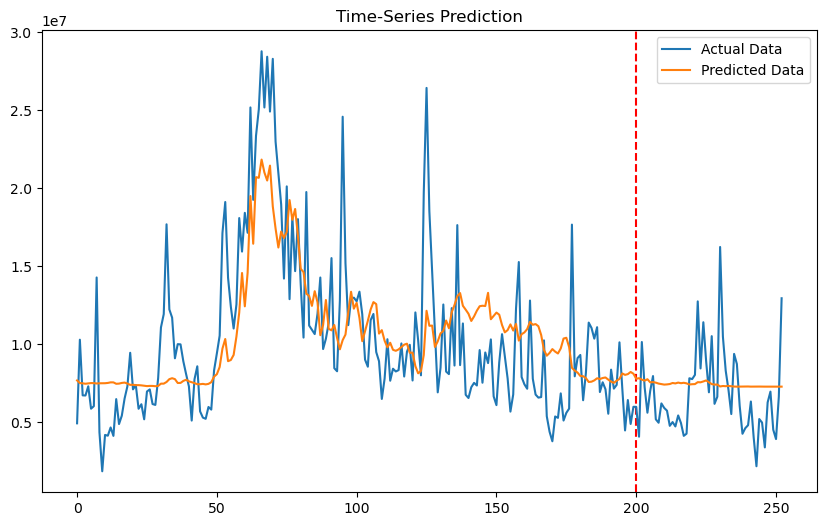

In [31]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 